### Knowledge Search and Discovery

In [1]:
import requests
import pandas as pd
from base64 import b64decode
from IPython import display
from pprint import PrettyPrinter
ppr=PrettyPrinter(width=150)

XDD_API_BASE_URL="https://xdd.wisc.edu/api/articles?dataset=xdd-covid-19&match=true&max=10"
XDD_ASKEM_BASE_URL="https://xdddev.chtc.io/askem/object?"
pd.set_option('display.max_colwidth', None)
def get_doi(xddid):
    resp = requests.get(f"{XDD_API_BASE_URL}&docid={xddid}&fields=doi&corpus=default")
    return resp.json()['success']['data']['data'][0]['doi']


# Scenario 1 - Interventions to Meet a Goal 
## Literature review - Interventions and hospitalizations

We start with a very naive approach: what literature in the xdd-covid-19 dataset talks about hospital capacity? We can search xDD, using the new `match` parameter (with behind-the-scenes improvements to recall) along with the new  `additional_fields` parameter to search title (and/or abstract) in addition to the full text:

In [2]:
resp = requests.get(f"{XDD_API_BASE_URL}&term=hospital capacity&additional_fields=title")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    xddid = d["_gddid"]
    doi = list(filter(lambda i: i["type"]=="doi", d["identifier"]))[0]['id']
    link = list(filter(lambda i: i['type']=="publisher", d["link"]))[0]["url"]
    data.append((xddid, doi, d['title'], d['abstract'], link))
pd.DataFrame(data, columns=["xddid", "DOI", "Title", "Abstract", "Link"])


,xddid,DOI,Title,Abstract,Link
0,630790cc2cc8300dbba986b6,10.1101/2022.08.23.22279122,Hospital bed capacity across in Tunisia hospital during the first four waves of the COVID-19 pandemic: A descriptive analysis,"<p>Background: \nOn March 11, 2020, WHO announced that the COVID-19 epidemic had passed the pandemic stage, indicating its spread over several continents. Tunisia9s containment and targeted screening strategy corresponded to the first WHO guidelines. \nSince then, public health policy has been more flexible and focused on the management of hospital beds. \n Objective: \n Our aims are to analyze bed occupancies for public hospitals and time delay reponse from the health care system in regard to the epidemiological situation.\n\n Methods: \nWe have analyzed the evolution of daily cases in relation to the different NPI actions undertaken by the Tunisian Government between March 2019 and February 2022 using the CoMo model.\nWe have also studied the flexibility of the O2 and ICU public hospital bed occupancies. We have used three distinct indices to assess this flexibility: the Ramp Duration Until the Peak (RDUP), which measures the duration of the wave/bed allocation effort. The Ramp Growth Until the Peak (RGUP), measures the peak height, and Ramp Rate Until the Peak (RRUP) measures the growth rate of the wave.\n Also, in order to evaluate the government response efficacy, we have calculated the time delay at the start (resp. at peak) of each two waves. \n\n Results:\n1. The evolution of the epidemic in Tunisia was divided into two phases, the first of which corresponded to the initial wave, during which the pandemic was controlled due to very strong NPI actions.\nThe second phase was distinguished by a progressive relaxation of measures and an increase in wave intensity.\n2. ICU bed availability has followed the demand for beds, while ICU bed occupancy has always been higher than 85% with a maximum of 97%.\n3. In terms of bed distribution, the government9s response was slow (9.4 days for the 02 beds and 18.2 days for the ICU beds).\nThe same may be said for the reaction in terms of bed reallocation in the original departments (16 days for ICU beds and 10.6 days for O2 beds).</p>",https://www.medrxiv.org/content/10.1101/2022.08.23.22279122v1
1,60114a25ea8bd37226971ee3,10.7326/M20-1260,Locally Informed Simulation to Predict Hospital Capacity Needs During the COVID-19 Pandemic,,https://www.acpjournals.org/doi/10.7326/M20-1260
2,5a23d95bcf58f1215aa46a41,10.1016/S0140-6736(06)69808-5,Inpatient disposition classification for the creation of hospital surge capacity: a multiphase study,,https://www.sciencedirect.com/science/article/pii/S0140673606698085
3,5fc506f1d76fca4a3f0cf447,10.1016/j.jss.2020.11.062,A Closer Look into Global Hospital Beds Capacity and Resource Shortages during the COVID-19 Pandemic,,https://www.sciencedirect.com/science/article/pii/S002248042030812X?v=s5
4,5ee16165725b01fb004047ed,10.1016/j.annemergmed.2020.05.001,Emerging success against Covid-19 pandemic: Hospital surge capacity in Taiwan,,https://www.sciencedirect.com/science/article/pii/S0196064420303437?v=s5
5,5e9485e0998e17af826aad19,10.1111/anae.15072,Hospital surge capacity in a tertiary emergency referral centre during the COVID-19 outbreak in Italy,,http://doi.wiley.com/10.1111/anae.15072
6,5eb084b0998e17af826d165a,10.1101/2020.04.29.20066506,"Balancing revenue generation with capacity generation: Case distribution, financial impact and hospital capacity changes from cancelling or resuming elective surgeries in the US during COVID-19","<p>Background:\nTo increase bed capacity and resources, hospitals have postponed elective surgeries, although the financial impact of this decision is unknown. We sought to report elective surgical case distribution, associated gross hospital earnings and regional hospital and intensive care unit (ICU) bed capacity as elective surgical cases are cancelled and then resumed under simulated trends of COVID-19 incidenc

The new `match` logic is a more Google-like query, rather than the default phrase-based approach. Each individual term is searched for within the documents, with each documents' score being influenced by the terms' relative frequency. Recall is greatly boosted by the **pre-definition of the relevant corpus**, which is an additional context filter enforcing (in this case) identified relevance to covid-19 in addition to the target query terms. The corpus (or dataset) definition is one place we're aiming to leverage the DKG in order to 

The first article appears to be about an analysis done in Tunisia and won't help us simulate the effect of interventions. The second article is about the impact of classifying patients. But the third is interesting. Unfortunately we don't have the abstract for this, so we can't tell at a glance what model (if any!) it uses. So let's query xDD again, this time to retrieve usage of the word "model" within this document. We also want to know what URLs are present in the paper, hoping for links to source code (`known_entities=url_extractions`).

In [3]:
resp = requests.get(f"{XDD_API_BASE_URL}&docid=60114a25ea8bd37226971ee3&term=model&include_highlights=true&known_entities=url_extractions")
rdata = resp.json()['success']['data']
ppr.pprint(rdata)
                                                                      

[{'_gddid': '60114a25ea8bd37226971ee3',
  '_highlight': [' instantiation of a susceptible, infected, removed (SIR) <em class="hl">model</em> with a 1-day cycle. Setting: 3',
                 '. Measurements: The COVID-19 Hospital Impact <em class="hl">Model</em> (CHIME) (http://penn-chime.phl.io) SIR <em '
                 'class="hl">model</em> was used',
                 ' hospitals, including 338 to 1608 ICU beds and 118 to 599 ventilators. Limitations: <em class="hl">Model</em> parameters',
                 ' states to <em class="hl">model</em> infection severity, social networks to <em class="hl">model</em> transmission dynamics, or '
                 'geographic',
                 ' and designed for hospital operations leaders, this <em class="hl">modeling</em> tool can inform preparations for capacity strain'],
  'abstract': '',
  'author': [{'name': 'Weissman, Gary E.'},
             {'name': 'Crane-Droesch, Andrew'},
             {'name': 'Chivers, Corey'},
             {'name

This looks promising! We could start exploring the CHIME model (and we know where to find the code). But we're interested in finding simulations that include interventions. So let's flag this document as interesting and keep searching, this time looking for models that handle social distancing inteventions: a search query of "model simulation hospital capacity social distancing". We'll leverage the title and abstract (if present) in the search and again, we'll bring back the url extractions. 

### Using figures to guide document relevance

In [4]:
resp = requests.get(f"{XDD_API_BASE_URL}&term=model simulation hospital capacity social distancing&additional_fields=title,abstract&known_entities=url_extractions")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    xddid = d["_gddid"]
    doi = list(filter(lambda i: i["type"]=="doi", d["identifier"]))[0]['id']
    link = list(filter(lambda i: i['type']=="publisher", d["link"]))[0]["url"]
    data.append((xddid, doi, d['title'], d['abstract'], link))
pd.DataFrame(data, columns=["xddid", "DOI", "Title", "Abstract", "Link"])

,xddid,DOI,Title,Abstract,Link
0,5e8cec3d998e17af826a70df,10.1101/2020.04.05.20054775,Increased Detection coupled with Social Distancing and Health Capacity Planning Reduce the Burden of COVID-19 Cases and Fatalities: A Proof of Concept Study using a Stochastic Computational Simulation Model,"<p>Objective: In absence of any vaccine, the Corona Virus Disease 2019 (COVID-19) pandemic is being contained through a non-pharmaceutical measure termed Social Distancing (SD). However, whether SD alone is enough to flatten the epidemic curve is debatable. Using a Stochastic Computational Simulation Model, we investigated the impact of increasing SD, hospital beds and COVID-19 detection rates in preventing COVID-19 cases and fatalities.\nResearch Design and Methods: The Stochastic Simulation Model was built using the EpiModel package in R. As a proof of concept study, we ran the simulation on Kasaragod, the most affected district in Kerala. We added 3 compartments to the SEIR model to obtain a SEIQHRF (Susceptible-Exposed-Infectious-Quarantined-Hospitalised-Recovered-Fatal) model.\nResults: Implementing SD only delayed the appearance of peak prevalence of COVID-19 cases. Doubling of hospital beds could not reduce the fatal cases probably due to its overwhelming number compared to the hospital beds. Increasing detection rates could significantly flatten the curve and reduce the peak prevalence of cases (increasing detection rate by 5 times could reduce case number to half).\nConclusions: An effective strategy to contain the epidemic spread of COVID-19 in India is to increase detection rates in combination with SD measures and increase in hospital beds.</p>",https://www.medrxiv.org/content/10.1101/2020.04.05.20054775v1
1,5ea2e544998e17af826bb787,10.1101/2020.04.20.20073213,"A model-based evaluation of the efficacy of COVID-19 social distancing, testing and hospital triage policies","<p>We present a stochastic compartmental network model of SARS-CoV-2 and COVID-19 exploring the effects of policy choices in three domains: social distancing, hospital triaging, and testing. We distinguished between high-risk and low-risk members of the population, and modeled differences in social interactions due to context, risk level, infection status, and testing status. The model incorporates many of the currently important characteristics of the disease, including overcapacity in the healthcare system and uncertainties surrounding the proportion and transmission potential of asymptomatic cases. We compared current policy guidelines from public health agencies with alternative options, and investigated the effects of policy decisions on the overall proportion of COVID-19-related deaths. Our results support current policies to contain the outbreak but also suggest possible refinements, including emphasizing the need to reduce public, random contacts more than private contacts, and testing low-risk symptomatic individuals before high-risk symptomatic individuals. Our model furthermore points to interactions among the three policy domains; the efficacy of a particular policy choice depends on other implemented policies. Finally, our results provide an explanation for why societies like Germany, with lower average rates of social contact, are more successful at containing the outbreak than highly social societies such as Italy, despite the implementation of similar policy measures.</p>",https://www.medrxiv.org/content/10.1101/2020.04.20.20073213v1
2,5eea812198406a60e3e3636f,10.1101/2020.06.07.20124859,Impact of Timing of and Adherence to Social Distancing Measures on COVID-19 Burden in the US: A Simulation Modeling Approach,"<p>Background: Across the U.S., various social distancing measures were implemented to control COVID-19 pandemic. However, there is uncertainty in the effectiveness of such measures for specific regions with varying population demographics and different levels of adherence to social distancing. The objective of this paper is to determine 

The top few results all look compelling, the first mentions adding compartments to create a Susceptible-Exposed-Infectious-Quarantined-Hospitalised-Recovered-Fatal (SEIQHRF) model, but its study focus was Kasaragod. By looking at the figure extractions from the second one, we see more information about the model used:

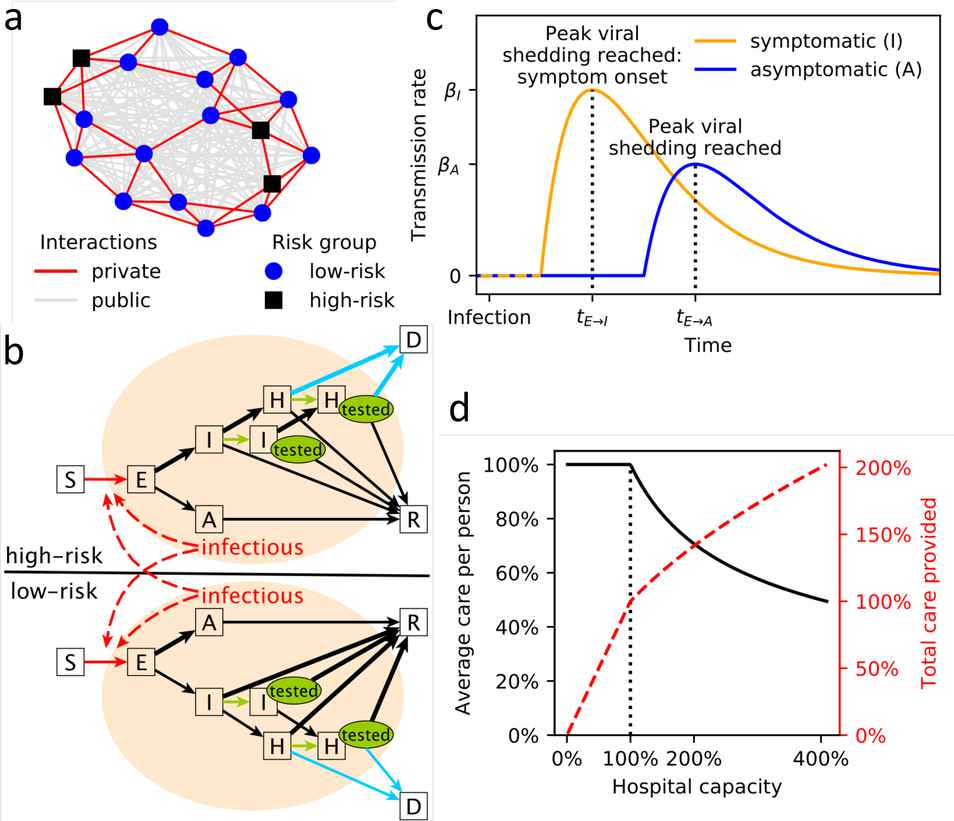

In [5]:
url = f"http://xdddev.chtc.io/askem/object?askem_class=Figure&doi=10.1101/2020.04.20.20073213"
resp = requests.get(url)
data = resp.json()
result = data["success"]["data"][0] # Let's take a look at the first table in the response.
display.Image(b64decode(result['properties']['image']))


In [6]:
print(result['properties']['caption'])

Figure 1: (a) Example of the two-layer interaction network used in this study. The private, small-world net- work (red edges) is shown on top of the public, fully-connected network (gray edges). Low-risk (blue circles) and high-risk (black squares) individuals are distinguished. (b) Illustration of the stochastic transmission model with compartments S = susceptible, E = exposed, A = asymptomatic, I = symptomatic, H = hospi- talized, R = recovered, D = deceased. Individuals in I and H may received a positive test (green "tested" oval). Edges that are influenced by policy decisions are colored: red = social distancing, green = testing, blue = hospital triage. Branching probabilities at E, I and H are risk-group dependent and the edge of the respectively more likely transition is thicker. (c) Illustration of the time-dependent transmission rate of an exposed individual increasing until peak viral shedding, which coincides with transition to compartment I (if symptomatic) or A (otherwise).

### Documents with shared resources

The third document `10.1101/2020.06.07.20124859` is explicitly about the US, and is an agent-based simulation. Let's see what URLs were extracted.

In [7]:
doc_of_interest = list(filter(lambda i: i["_gddid"]=="5eea812198406a60e3e3636f", rdata))[0]
data = []
for i in sorted(doc_of_interest['known_entities']['url_extractions'], key=lambda x: -len(x['extracted_from'])):
    extracted_from = i['extracted_from']
    extracted_from_dois = [get_doi(j) for j in extracted_from]
    #ppr.pprint((i['url'], i['resource_title'], i['extracted_from'], extracted_from_dois))
    data.append((i['url'], i['resource_title'], extracted_from_dois))
pd.DataFrame(data, columns=["URL", "Resource Title", "DOIS"])

,URL,Resource Title,DOIS
0,https://www.google.com/covid19/mobility/.,COVID-19 Community Mobility Reports,"[10.1101/2020.06.07.20124859, 10.1101/2020.04.21.20074732, 10.1101/2021.03.22.21254131]"
1,https://penn-chime.phl.io/.,Streamlit,"[10.1101/2020.06.07.20124859, 10.1101/2020.03.27.20043752]"
2,https://www.dhs.wisconsin.gov/covid-19/data.htm.,COVID-19: Wisconsin Summary Data | Wisconsin Department of Health Services,"[10.1101/2020.06.07.20124859, 10.1101/2021.03.22.21254131]"
3,https://www.unacast.com/covid19/social-distancing-scoreboard.,Social Distancing Scoreboard,"[10.1101/2020.06.07.20124859, 10.1101/2020.12.01.20241984]"
4,https://geods.geography.wisc.edu/covid19/physical-distancing/.,Mapping Mobility Changes in Response to COVID-19,"[10.1101/2020.06.07.20124859, 10.1101/2021.03.22.21254131]"
5,https://doi.org/10.1016/s0140-6736(20)30985-5,Redirecting,[10.1101/2020.06.07.20124859]
6,https://data.census.gov/cedsci/.,Explore Census Data,[10.1101/2020.06.07.20124859]
7,https://alhill.shinyapps.io/covid19seir/.,Modeling COVID-19 Spread vs Healthcare Capacity,[10.1101/2020.06.07.20124859]
8,https://doi.org/10.3201/eid2606.200357,"Serial Interval of COVID-19 among Publicly Reported Confirmed Cases - Volume 26, Number 6—June 2020 - Emerging Infectious Diseases journal - CDC",[10.1101/2020.06.07.20124859]
9,https://doi.org/10.1101/2020.03.12.20034728,Spread of SARS-CoV-2 Coronavirus likely constrained by climate | medRxiv,[10.1101/2020.06.07.20124859]


Mobility data, a CHIME interface, Wisconsin covid data. Of special interest is the overlap between documents citing these extractions: `5eea812198406a60e3e3636f` (this document) and `605b72713f2ac7e7014fd629` seem to share resources. Let's look at the metadata for these two articles:

In [8]:
resp = requests.get("https://xdd.wisc.edu/api/articles?docids=5eea812198406a60e3e3636f,605b72713f2ac7e7014fd629")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    xddid = d["_gddid"]
    doi = list(filter(lambda i: i["type"]=="doi", d["identifier"]))[0]['id']
    link = list(filter(lambda i: i['type']=="publisher", d["link"]))[0]["url"]
    authors = "; ".join([i['name'] for i in d['author']])
    data.append((xddid, doi, d['title'], authors, d['year'], link))
pd.DataFrame(data, columns=["xddid", "DOI", "Title", "Authors", "Year", "Link"])

,xddid,DOI,Title,Authors,Year,Link
0,5eea812198406a60e3e3636f,10.1101/2020.06.07.20124859,Impact of Timing of and Adherence to Social Distancing Measures on COVID-19 Burden in the US: A Simulation Modeling Approach,Oguzhan Alagoz; Ajay Sethi; Brian Patterson; Matthew Churpek; Nasia Safdar,2020,https://www.medrxiv.org/content/10.1101/2020.06.07.20124859v1
1,605b72713f2ac7e7014fd629,10.1101/2021.03.22.21254131,The Impact of Vaccination to Control COVID-19 Burden in the United States: A Simulation Modeling Approach,Oguzhan Alagoz; Ajay Sethi; Brian Patterson; Matthew Churpek; Ghalib Alhanaee; Elizabeth Scaria; Nasia Safdar,2021,https://www.medrxiv.org/content/10.1101/2021.03.22.21254131v1


Same authors, but the newer article focuses on the impact of vaccination.

**NOTE** This work is still in development, so only a subset of documents have been processed. Further processing, along with functionality for resource-first lookup are targeted for January.


### Masking
Finally, let's see if we can find information about the impact of masking to New York City in particular. A search query of "new york city model simulation hospital capacity masking": 

In [9]:
data = []
resp = requests.get(f"{XDD_API_BASE_URL}&term=new york city model simulation hospital capacity masking&additional_fields=title,abstract")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    xddid = d["_gddid"]
    doi = list(filter(lambda i: i["type"]=="doi", d["identifier"]))[0]['id']
    link = list(filter(lambda i: i['type']=="publisher", d["link"]))[0]["url"]
    data.append((xddid, doi, d['title'], d['abstract'], link))
pd.DataFrame(data, columns=["xddid", "DOI", "Title", "Abstract", "Link"])


,xddid,DOI,Title,Abstract,Link
0,61be401d03cbbf5cb75962bd,10.1101/2021.12.18.21268024,Vaccine efficacy for COVID-19 outbreak in New York City,<p>This article aims to study the COVID-19 data for New York City. We use both the daily number of second does vaccination and the daily number of reported cases for New York City. This article provides a method to combine an epidemic model and such data. We explore the influence of vaccine efficacy on our results.</p>,https://www.medrxiv.org/content/10.1101/2021.12.18.21268024v1
1,5f3bef4ba58f1dfd5211ef2c,10.1101/2020.08.16.20175992,Acute Peritoneal Dialysis During the COVID-19 Pandemic at Bellevue Hospital in New York City,"<p>The COVID-19 pandemic created an unprecedented strain on hospitals in New York City. Although practitioners focused on the pulmonary devastation, resources for the provision of dialysis proved to be more constrained. To deal with these shortfalls, NYC Health and Hospitals/Bellevue, NYU Brooklyn, NYU Medical Center and the New York Harbor VA Healthcare System, put together a plan to offset the anticipated increased needs for kidney replacement therapy. \n\nPrior to the pandemic, peritoneal dialysis was not used for acute kidney injury at Bellevue Hospital. We were able to rapidly establish an acute peritoneal dialysis program at Bellevue Hospital for acute kidney injury patients in the intensive care unit. A dedicated surgery team was assembled to work with the nephrologists for bedside placement of the peritoneal dialysis catheters. A multi-disciplinary team was trained by the lead nephrologist to deliver peritoneal dialysis in the intensive care unit. Between April 8, 2020 and May 8, 2020, 39 peritoneal dialysis catheters were placed at Bellevue Hospital. 38 patients were successfully started on peritoneal dialysis. As of June 10, 2020, 16 patients recovered renal function. One end stage kidney disease patient was converted to peritoneal dialysis and was discharged. One catheter was poorly functioning, and the patient was changed to hemodialysis before recovering renal function. There were no episodes of peritonitis and nine incidents of minor leaking, which resolved. Some patients received successful peritoneal dialysis while being ventilated in the prone position.\n\n\nIn summary, despite severe shortages of staff, supplies and dialysis machines during the COVID-19 pandemic, we were able to rapidly implement a de novo peritoneal dialysis program which enabled provision of adequate kidney replacement therapy to all admitted patients who needed it. Our experience is a model for the use of acute peritoneal dialysis in crisis situations.</p>",https://www.medrxiv.org/content/10.1101/2020.08.16.20175992v1
2,5fa7537c853f777558f7912c,10.1101/2020.11.05.20226530,"Medical Capacity Shortages Facilitated the Rapid Dissemination of COVID-19 in Wuhan, New York State, and Italy","<p>During the coronavirus disease 2019 (COVID-19) outbreak, every public health system faced the potential challenge of medical capacity shortages. Infections without timely diagnosis or treatment may facilitate the stealth transmission and spread of the virus. Using infection and medical capacity information reported in Wuhan in China, New York State in the United States, and Italy, we developed a dynamic susceptible-exposed-infected-recovered (SEIR) model to estimate the impact of medical capacity shortages during the COVID-19 outbreak at the city, state, and country levels. After accounting for the effects of travel restrictions and control measures, we find that the number of infections in Wuhan could have been 39% lower than the actual number if the medical capacity were doubled in this city. Similarly, we find the less shortages in medical capacity in both New York state and Italy, the faster decline in the daily infection numbers and the fewer deaths. This study provides a method for estimating potential shortages and explains how they may dynamically facilitate disease spreading during futur

Again, results are a mix of promising documents and relevant, but not immediately actionable, analyses. We could investigate them using the tools above to better understand them, or use the provided links to view them directly. For example, discovered datasets can be handed to Jataware tools to improve their structure and prepare them for utilization, or source code can be processed to canonical representations.

## Model search

Another feature of xDD is the ability to register, index, and retrieve arbitrary objects, including GrometFNs. While the full metadata mapping to enable precise querying is not yet present, xDD currently concatenates all text fields into one searchable text field. In this way, models can be rudimentarily searched for parameters, source code variables, comments, or any other distinguishing text. For example, we can look for models that include a "doubling_time" parameter:

In [10]:
resp = requests.get(f"{XDD_ASKEM_BASE_URL}&query_all=doubling_time")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    data.append((d['name'], d['ASKEM_ID'], d['schema'], d['schema_version']))
pd.DataFrame(data, columns=["Name", "ASKEM_ID", "schema", "schema_version"])

,Name,ASKEM_ID,schema,schema_version
0,CHIME_SIR,223f8a21-1e38-4b59-bddf-ca21b9cd48e7,FN,0.1.4
1,CHIME_SVIIvR,a676e836-359c-4bbd-aa00-4014cc0a8f76,FN,0.1.4


Or models that mention "vaccination_rate":

In [11]:
resp = requests.get(f"{XDD_ASKEM_BASE_URL}&query_all=vaccination_rate")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    data.append((d['name'], d['ASKEM_ID'], d['schema'], d['schema_version']))
pd.DataFrame(data, columns=["Name", "ASKEM_ID", "schema", "schema_version"])


,Name,ASKEM_ID,schema,schema_version
0,CHIME_SVIIvR,a676e836-359c-4bbd-aa00-4014cc0a8f76,FN,0.1.4


In [12]:
rdata[0]["attributes"]

[{'type': 'FN',
  'value': {'b': [{'function_type': 'FUNCTION',
     'name': 'get_beta',
     'metadata': 3}],
   'opi': [{'id': 1, 'name': 'intrinsic_growth_rate', 'box': 1, 'metadata': 4},
    {'id': 2, 'name': 'gamma', 'box': 1, 'metadata': 5},
    {'id': 3, 'name': 'susceptible', 'box': 1, 'metadata': 6},
    {'id': 4, 'name': 'relative_contact_rate', 'box': 1, 'metadata': 7}],
   'opo': [{'id': 1, 'box': 1}],
   'bf': [{'function_type': 'EXPRESSION', 'contents': 2, 'metadata': 10},
    {'function_type': 'EXPRESSION', 'contents': 3, 'metadata': 12},
    {'function_type': 'EXPRESSION', 'contents': 4, 'metadata': 15}],
   'pif': [{'id': 1, 'box': 1},
    {'id': 1, 'box': 2},
    {'id': 2, 'box': 2},
    {'id': 1, 'box': 3},
    {'id': 2, 'box': 3},
    {'id': 3, 'box': 3}],
   'pof': [{'id': 1, 'name': 'inv_contact_rate', 'box': 1},
    {'id': 1, 'name': 'updated_growth_rate', 'box': 2},
    {'id': 1, 'name': 'beta', 'box': 3}],
   'wfopi': [{'src': 1, 'tgt': 4},
    {'src': 2, 'tgt'

Or the model names themselves can be searched:

In [13]:
resp = requests.get(f"{XDD_ASKEM_BASE_URL}&query_all=bucky")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    data.append((d['name'], d['ASKEM_ID'], d['schema'], d['schema_version']))
pd.DataFrame(data, columns=["Name", "ASKEM_ID", "schema", "schema_version"])


,Name,ASKEM_ID,schema,schema_version
0,bucky_simplified_v1,15409047-01a5-4052-b40a-46ac302d27ce,FN,0.1.4


In [14]:
rdata[0]['attributes']

[{'type': 'IMPORT',
  'value': {'name': 'warnings.simplefilter',
   'src_language': 'Python',
   'type': 'NATIVE',
   'version': '3.8'}},
 {'type': 'IMPORT',
  'value': {'name': 'warnings.simplefilter',
   'src_language': 'Python',
   'type': 'NATIVE',
   'version': '3.8'}},
 {'type': 'FN',
  'value': {'b': [{'function_type': 'FUNCTION',
     'name': 'new:TqdmLoggingHandler'}],
   'opi': [{'id': 1, 'name': 'record', 'box': 1}],
   'opo': [{'id': 1, 'box': 1}],
   'bf': [{'function_type': 'LITERAL',
     'value': {'value_type': 'string', 'value': 'TqdmLoggingHandler'}},
    {'function_type': 'PRIMITIVE', 'name': 'new_Record'}],
   'pif': [{'id': 1, 'box': 2}],
   'pof': [{'id': 1, 'box': 1}, {'id': 1, 'box': 2}],
   'wff': [{'src': 1, 'tgt': 1}],
   'wfopo': [{'src': 1, 'tgt': 2}]}},
 {'type': 'FN',
  'value': {'b': [{'function_type': 'FUNCTION', 'name': 'new:dotdict'}],
   'opi': [{'id': 1, 'name': 'memo', 'box': 1}],
   'opo': [{'id': 1, 'box': 1}],
   'bf': [{'function_type': 'LITERA

# Scenario 2 - Vaccination and age stratification
## Literature review
### Future plan: Method summarization

In [15]:
resp = requests.get(f"{XDD_API_BASE_URL}&term=simulation model age stratification vaccine&additional_fields=title,abstract")
rdata = resp.json()['success']['data']
data = []
for d in rdata:
    xddid = d["_gddid"]
    doi = list(filter(lambda i: i["type"]=="doi", d["identifier"]))[0]['id']
    link = list(filter(lambda i: i['type']=="publisher", d["link"]))[0]["url"]
    data.append((xddid, doi, d['title'], d['abstract'], link))
pd.DataFrame(data, columns=["xddid", "DOI", "Title", "Abstract", "Link"])

,xddid,DOI,Title,Abstract,Link
0,604630663f2ac7e7017b317f,10.1101/2021.03.04.21251264,Comparison of COVID-19 vaccine prioritization strategies in the United States,"<p>A critical question in the COVID-19 pandemic is how to optimally allocate the first available vaccinations to maximize health impact. We used a static simulation model with detailed demographic and risk factor stratification to compare the impact of different vaccine prioritization strategies in the United States on key health outcomes, using California as a case example. We calibrated the model to demographic and location data on 28,175 COVID-19 deaths in California up to December 30, 2020, and incorporated variation in risk by occupation and comorbidity status using published estimates. We predicted the proportion of COVID-19 clinical cases, deaths and disability-adjusted life years (DALYs) averted over 6 months relative to a scenario of no vaccination for five vaccination strategies that prioritized vaccination by a single risk factor: random allocation; targeting special populations (e.g. incarcerated individuals); targeting older individuals; targeting essential workers; and targeting individuals with comorbidities. Targeting older individuals averted the highest proportion of DALYs (40% for 5 million individuals vaccinated) and deaths (65%) but the lowest proportion of cases (12%). Targeting essential workers averted the lowest proportion of DALYs (25%) and deaths (33%). Allocating vaccinations simultaneously by age and location or by age, sex, race/ethnicity, location, occupation, and comorbidity status averted a significantly higher proportion of DALYs (48% and 56%) than any strategy prioritizing by a single risk factor. Our results corroborate findings of other studies that age targeting is the best single-risk-factor prioritization strategy for averting DALYs, and suggest that targeting by multiple risk factors would provide additional benefit.</p>",https://www.medrxiv.org/content/10.1101/2021.03.04.21251264v1
1,5f5a098ea58f1dfd52149913,10.1101/2020.09.08.20190629,Model-informed COVID-19 vaccine prioritization strategies by age and serostatus,"<p>When a vaccine for COVID-19 becomes available, limited initial supply will raise the question of how to prioritize the available doses and thus underscores the need for transparent, evidence-based strategies that relate knowledge of, and uncertainty in, disease transmission, risk, vaccine efficacy, and existing population immunity. Here, we employ a model-informed approach to vaccine prioritization that evaluates the impact of prioritization strategies on cumulative incidence and mortality and accounts for population factors such as age, contact structure, and seroprevalence, and vaccine factors including imperfect and age-varying efficacy. This framework can be used to evaluate and compare existing strategies, and it can also be used to derive an optimal prioritization strategy to minimize mortality or incidence. We find that a transmission-blocking vaccine should be prioritized to adults ages 20-49y to minimize cumulative incidence and to adults over 60y to minimize mortality. Direct vaccination of adults over 60y minimizes mortality for vaccines that do not block transmission. We also estimate the potential benefit of using individual-level serological tests to redirect doses to only seronegative individuals, improving the marginal impact of each dose. We argue that this serology-informed vaccination approach may improve the efficiency of vaccination efforts while partially addressing existing inequities in COVID-19 burden and impact.</p>",https://www.medrxiv.org/content/10.1101/2020.09.08.20190629v1
2,6051ffb63f2ac7e7012b4b9e,10.1101/2021.03.14.21253555,Impact of booster COVID-19 vaccine for Moroccan adults: A discrete age-structured model approach,"<p>Public health control strategies, such as lockdown, seem to be effective in reducing the spread of the pandemic, but are ineffective as a whole since lockdo

5f5a098ea58f1dfd52149913 (10.1101/2020.09.08.20190629) looks promising, but we can't tell from the abstract (or the above-used `model` context trick). However, it's clear from a quick survey of the Methods section makes it clear:

> Methods

> We used a continuous-time, ODE-based compartmental model stratified by age. The model compartments (Si, Ei, Ii, Ri, Vi), described below, represent mutually exclusive epidemiological states stratified by age group i, i ∈ {0-9, 10-19, . . . , 70-79, 80+}.

We are targeting initial extraction/summarization of text sections, especially "Methods" on the hackathon timeframe.

# Conclusions and Handoff

Through xDD, a user can discover:
1. Documents outlining research that has been done for a topic.
2. Artifacts extracted from those documents to help classify their significance or to surface additional relevant resources or documents.
3. Models and other items that have been registered, indexed, and sometimes pre-processed.

Additionally, xDD provides (as seen in the previous demo):
1. JSON/dataframe representations of extracted tables
2. Word and document embedding models trained over targeted corpora


These can be saved to a project space for later consumption, or can be further processed by other TA1 teams for further knowledge enrichment. For example, we showed a workflow above where a user could have discovered a paper leveraging the CHIME model along with extracted links to the source code. This code, its documentation, the origin document, and its artifacts can, as we'll see, be further enriched by other TA1 teams.